In [ ]:
import os

os.chdir('/Users/lilimatic/np_var_mis/')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from functions import *

import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.kernel_regression import KernelReg

from scipy.optimize import minimize
from multiprocess import Pool

/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
data = pd.read_excel('data.xlsx')

/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:
#
data = data.loc[(data['drug_name'] == 'Gemcitabine') & (data['cell_line'] == 'OCUBM')][['Drug_concentration (µM)',
                                                                               'viability1', 'viability2', 'viability3', 'viability4', 'viability5','viability6']]

X = np.log10(sum([data['Drug_concentration (µM)'].values.tolist()]*6,[]))
y= sum([data.iloc[:,i].values.tolist() for i in range(1,7)],[])

df = pd.DataFrame({'y':y,'X':X })

In [5]:
b0 = 0.8
b1 =  0.8

In [6]:
y = df.y
X= df.X

n = len(df)
h=0.15
omega = bernoulli.rvs(pi(y,b0,b1), size=n)

In [7]:
omega = bernoulli.rvs(pi(y,b0,b1), size=n)

df = pd.DataFrame({'x':X,'y':y,'omega':omega})

#ipw

df['y_pi'] =  df['y'].apply(lambda t: t/pi(t,b0,b1))

df['var'] = df['x'].apply(lambda t: sigma_reg(t,len(df)))

df_cc = df.loc[df['omega']==1].reset_index(drop=True)

In [8]:
size = round(len(df_cc)*100/len(df))
size

79

In [9]:
model = KernelReg(endog=[df.y],exog=[df.x],reg_type='lc',var_type='c', bw='cv_ls')


In [10]:
def r_parallel_cc(h):
    #print(1)
    def fn(j):
        df1 = df.drop([j],axis=0)
        y_hat = df.omega[j]*nw_mis(h,df.x[j],df1.x,df1.y,pi(df1.y,b0,b1),df1.omega)
        return df.omega[j]*(df.y[j]-y_hat)**2 #/pi(df.y[j],b0,b1)

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df))))

In [11]:
h_ipw = minimize(r_parallel_cc, 0.1).x

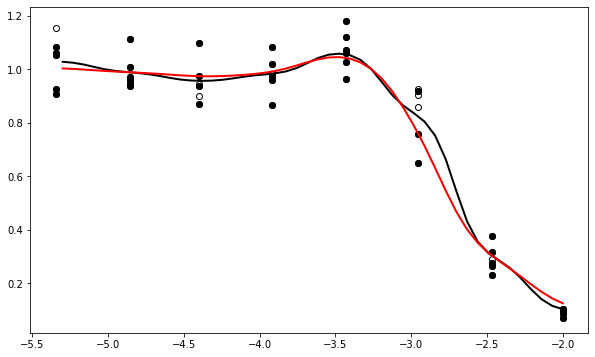

In [12]:
fig, ax = plt.subplots(1, 1,figsize=(10, 6))

plt.plot(df['x'],df['y'],'o',mfc='none',color='black')
plt.plot(df_cc['x'],df_cc['y'],'o',color='black')


#Full model 
ax.plot(np.linspace(-5.3, -2, n),model.fit(np.linspace(-5.3, -2, n))[0] ,color= 'black', lw=2)

#CC estimator 
#ax.plot(np.linspace(2.4, 57.6, n),model_cc.fit(np.linspace(2.4, 57.6, n))[0] ,color= 'blue', lw=2)

#IPW estimator 
ax.plot(np.linspace(-5.3, -2, n),[nw_mis(h_ipw,t,X,y,pi(y,b0,b1),omega) for t in np.linspace(-5.3, -2, n)],color= 'red', lw=2)

#plt.savefig(f'Mcyle_{size}.pdf',transparent=True)

In [13]:
df['res'] = (df['y'] - model.fit(df['x'])[0])**2
df_cc['res'] = (df_cc['y'] - df_cc['x'].apply(lambda t:nw_mis(h_ipw_cc,t,X,y,pi(y,b0,b1),omega)))**2

NameError: name 'h_ipw_cc' is not defined

In [ ]:
model_res = KernelReg(endog=[df.res],exog=[df.x],reg_type='lc',var_type='c', bw='cv_ls')


In [ ]:
def nw_mis(h,x,X,y,p,omega):
    #if h < 0.001:
    #    h = 0.001
    y = ((y*omega)/p)
    num = sum(y*norm.pdf((x-X)/h))
    dem = sum((omega/p)*norm.pdf((x-X)/h))
    return num/dem

In [ ]:
# Create a DataFrame using the array
df_ones = pd.DataFrame(np.ones(df_cc[['x']].shape))

def r_parallel_res(h):
    #print(1)
    def fn(j):
        df1 = df_cc.drop([j],axis=0)
        df_ones1 = df_ones.drop([j],axis=0)
        y_hat = nw_mis(h,df_cc.x[j],df1.x,df1.res,pi(df1.y,b0,b1),df_ones1[0])
        return (df_cc.res[j]-y_hat)**2 

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df_cc))))

In [ ]:
h_ipw_var = minimize(r_parallel_res, 0.16).x

h_ipw_var

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(10, 7))

plt.plot(df['x'],df['res'],'o',mfc='none',color='black')

plt.plot(df_cc['x'],df_cc['res'],'o',color='black')


#Full
ax.plot(np.linspace(-5.3, -2, n),model_res.fit(np.linspace(-5.3, -2, n))[0] ,color= 'black', lw=2)

#IPW
ax.plot(np.linspace(-5.3, -2, n),[sigma_mis_res(h_ipw_var,t,df_cc.x,df_cc.res,pi(df_cc.y,b0,b1),df_ones[0])**2 for t in np.linspace(-5.3, -2, n)],'-g',color= 'red', lw=2)

ax.set_ylim(0,0.007)

plt.savefig(f'figures/Residual_Bio_{size}.pdf',transparent=True)
